In [1]:
import os
import cv2
import json
import pickle
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from UNet import UNet
from metrics import iou_map
from callback import myCallback
from test import plot_model_history, model_layer_visualization

2022-05-19 22:01:48.515734: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/raphael/anaconda3/envs/sleap_dev/lib/python3.7/site-packages/cv2/../../lib64:
2022-05-19 22:01:48.515764: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_image_dir = "../sleap/our_data_train"
val_image_dir = "../sleap/our_data_val"

train_json_path = "../sleap/our_data_train.json"
val_json_path = "../sleap/our_data_val.json"

In [3]:
def preprocess_images(images_dir, img_dict):
    dataset_to_return = []
    for img in tqdm(os.listdir(images_dir)):
        img1 = cv2.imread(os.path.join(images_dir, img))
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img1 = cv2.resize(img1,(256, 256)) # shape
        norm_image = cv2.normalize(img1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        # norm_image = img1 / 255 
        output = get_output_images_with_multiconf(img_dict[img])
        dataset_to_return.append((norm_image, output))
    return dataset_to_return

In [4]:
def get_output_images_with_multiconf(centroid_output_points_arr):
    output_x_size, output_y_size = 128, 128
    new_img = np.zeros((output_x_size, output_y_size))
    c = centroid_output_points_arr[0][1], centroid_output_points_arr[1][1]
    c1 = {"x":int(c[0][0]*0.125), "y":int(c[0][1]*0.125)}
    c2 = {"x":int(c[1][0]*0.125), "y":int(c[1][1]*0.125)}
    sigma = 1

    for i in range(0, output_x_size):
        for j in range(0, output_y_size):
            cm_c1 = np.exp(-((i - c1["x"]) ** 2 + (j - c1["y"]) ** 2)/ (2 * sigma ** 2))
            cm_c2 = np.exp(-((i - c2["x"]) ** 2 + (j - c2["y"]) ** 2)/ (2 * sigma ** 2))
            new_img[j,i] = cm_c1 if cm_c2 < cm_c1 else cm_c2
    
    return new_img

In [ ]:
raw_images = []
with open(train_json_path, 'r') as r:
    info_json = json.loads(r.read())
# y = get_output_images_with_multiconf(centroid_output_points(info_json))

with open(val_json_path, 'r') as r:
    info_json_val = json.loads(r.read())
# y_val = get_output_images_with_multiconf(centroid_output_points(info_json_val))

x_train = preprocess_images(train_image_dir, info_json)
x_val = preprocess_images(val_image_dir, info_json_val)

 52%|███████████████████████▉                      | 831/1598 [01:12<00:57, 13.29it/s]

In [ ]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 6, 2):
    im = random.choice(x_train)
    ax1 = fig.add_subplot(3, 2, i)
    ax1.imshow(im[0])
    ax2 = fig.add_subplot(3, 2, i+1)
    ax2.imshow(im[1])

In [7]:
# pickle_out = open("/content/drive/MyDrive/flies_data/X_val.pickle","wb")
# pickle.dump(x_train, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/MyDrive/flies_data/X_val.pickle","wb")
# pickle.dump(x_val, pickle_out)
# pickle_out.close()

In [8]:
# x_train = pickle.load(open("/content/drive/MyDrive/flies_data/X_train.pickle","rb"))
# x_val = pickle.load(open("/content/drive/MyDrive/flies_data/X_val.pickle","rb"))

In [9]:
model = UNet()
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=[iou_map], run_eagerly=True)

2022-05-19 21:27:26.078179: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-05-19 21:27:34.803294: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-19 21:27:34.803356: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LT-0054): /proc/driver/nvidia/version does not exist
2022-05-19 21:27:34.804242: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-19 21:27:34.837887: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 1689600000 Hz
2022-05-19 21:27:34.838881: I tens

In [10]:
temp_x_train = np.array(list(map(lambda x: np.expand_dims(x[0], axis = 2), x_train)))
temp_y_train = np.array(list(map(lambda x: np.expand_dims(x[1], axis = 2), x_train)))
temp_x_val   = np.array(list(map(lambda x: np.expand_dims(x[0], axis = 2), x_val)))
temp_y_val   = np.array(list(map(lambda x: np.expand_dims(x[1], axis = 2), x_val)))

In [ ]:
callbacks = myCallback(this_max=True)
history = model.fit(temp_x_train, temp_y_train,
                    epochs=2,
                    validation_data=(temp_x_val, temp_y_val),
                    batch_size=32,
                    callbacks=[callbacks])

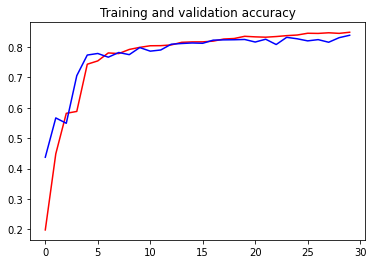

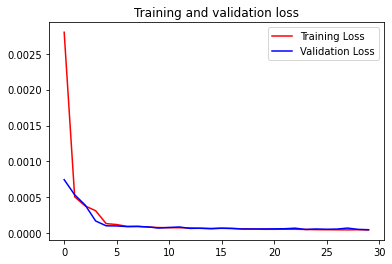

In [12]:
plot_model_history(history)

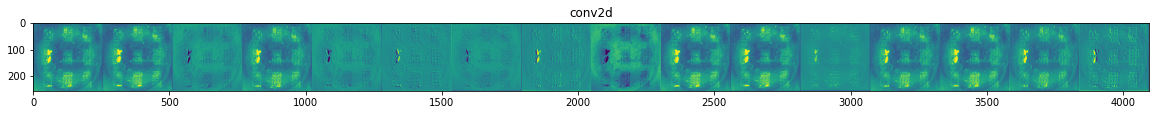

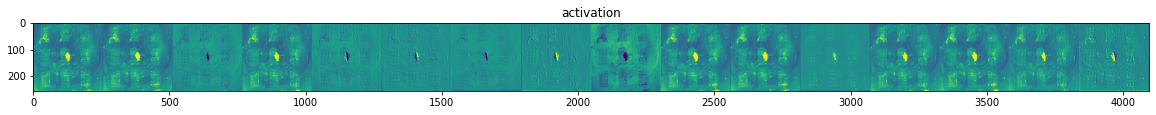

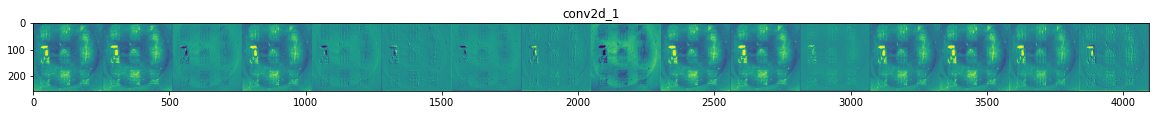

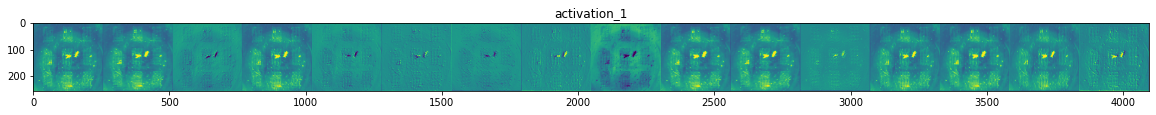

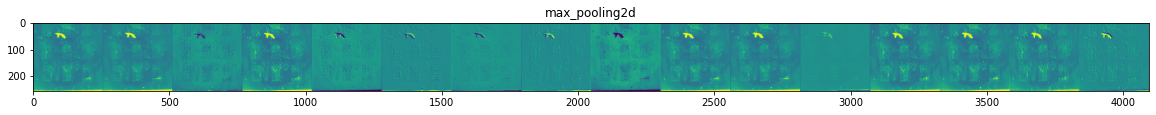

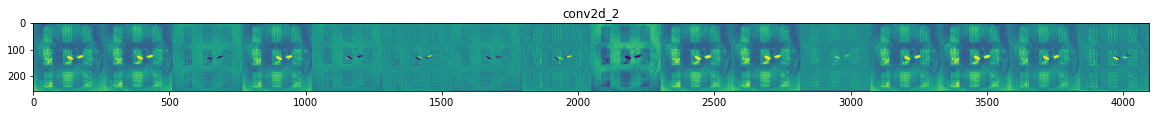

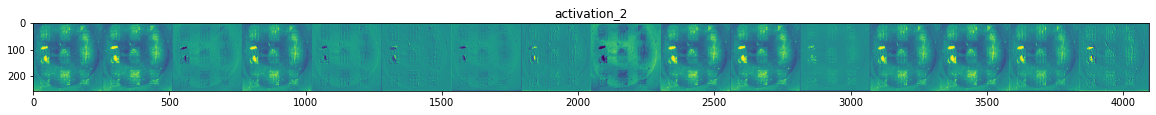

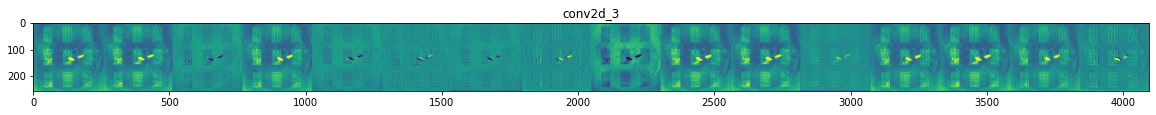

In [13]:
model_layer_visualization(model, temp_x_train)

In [14]:
model.load_weights('best_model_iou_80.h5')

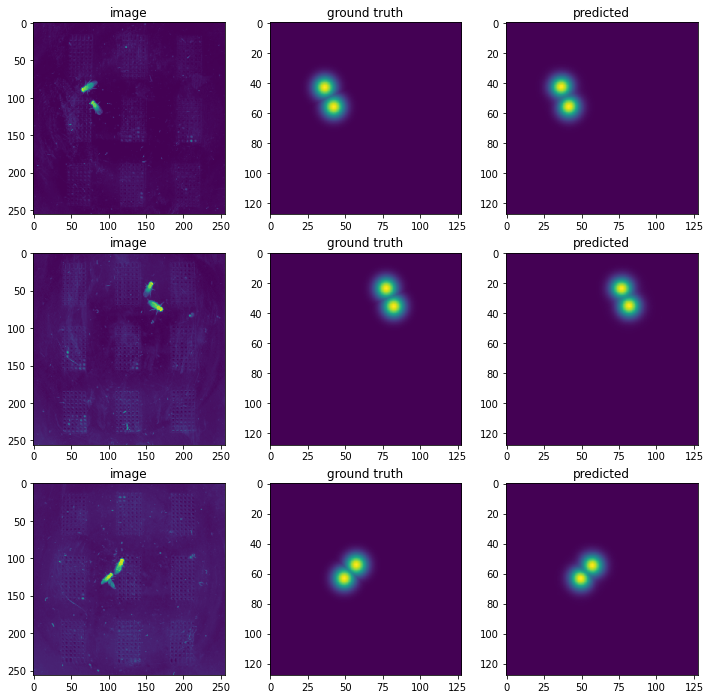

In [15]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 9, 3):
    img_index = random.randint(0, len(temp_x_val)-1) 
    im = temp_x_val[img_index]
    ax1 = fig.add_subplot(3, 3, i)
    ax1.imshow(im[:,:,0])
    ax1.set_title("image")
    
    im_true = temp_y_val[img_index]
    ax2 = fig.add_subplot(3, 3, i+1)
    ax2.imshow(im_true[:,:,0])
    ax2.set_title("ground truth")
    
    ax3 = fig.add_subplot(3, 3, i+2)
    im_predicted = model.predict(np.expand_dims(im, axis = 0))
    ax3.imshow(im_predicted[0,:,:,0])
    ax3.set_title("predicted")